In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import math
import yfinance as yf

2025-02-10 10:47:55.540326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [66]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
df = yf.download('NVDA', start='2017-02-01', end='2025-02-10')

[*********************100%***********************]  1 of 1 completed


In [4]:
df.to_csv('NVDA.csv')

In [5]:
df=pd.read_csv('NVDA.csv')

In [6]:
df1=df.reset_index()['Close']

In [7]:
df1 = df1[2:].reset_index(drop=True)

In [65]:
import shutil

df1_df = pd.DataFrame(df1)

# Save the processed file
df1_df.to_csv('NVDA.csv', index=False)

# Use shutil to move or copy the file to a desired location on your local system
shutil.move('NVDA.csv', '/Users/apple/Downloads/NVDA.csv')


'/Users/apple/Downloads/NVDA.csv'

In [8]:
df1

0       2.8070223331451416
1        2.842493772506714
2       2.8176145553588867
3        2.889791965484619
4       2.9346249103546143
               ...        
2012    116.66000366210938
2013     118.6500015258789
2014    124.83000183105469
2015    128.67999267578125
2016    129.83999633789062
Name: Close, Length: 2017, dtype: object

In [9]:
df1 = pd.to_numeric(df1, errors='coerce')

In [10]:
df1

0         2.807022
1         2.842494
2         2.817615
3         2.889792
4         2.934625
           ...    
2012    116.660004
2013    118.650002
2014    124.830002
2015    128.679993
2016    129.839996
Name: Close, Length: 2017, dtype: float64

In [11]:
df1=np.array(df1).reshape(-1,1)

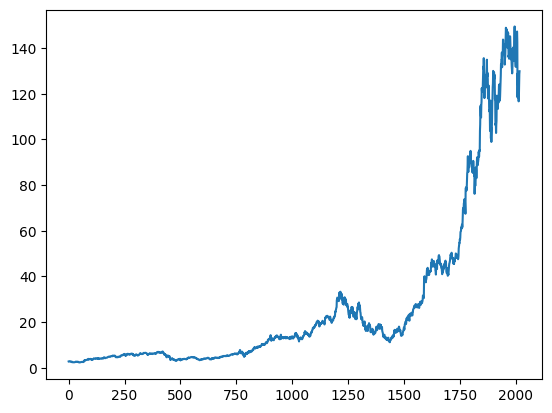

In [12]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [13]:
# these are integers values of the training size and testing size respectively
training_size = int(len(df1) * 0.8)
testing_size = len(df1) - training_size

In [14]:
train_data =df1[0:training_size, :]
test_data = df1[training_size:len(df1), :]

In [15]:
scaler=MinMaxScaler(feature_range=(0,1))

In [16]:
len(train_data),len(test_data)

(1613, 404)

In [17]:
#this is function for further dividing testing and training sets into input(x) and output(y) in both 
#input x will consist of elements 0-99 corresponding ooutput y will contain 1 entry of the 100th element 
#like this we will have 593 sets in train set and 197 sets in test set
def create_dataset(dataset, time_step=1):
    x, y = [], []
    for i in range(len(dataset) - time_step - 1):
        x.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(x), np.array(y)

In [18]:
time_step = 100  # Using 100 days as the time window
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [19]:
x_train = scaler.fit_transform(x_train) #fit transform only training data
x_test = scaler.transform(x_test) #only transform testing data

In [20]:
y_train = scaler.fit_transform(y_train.reshape(-1, 1)) #fit transform only training data
y_test = scaler.transform(y_test.reshape(-1, 1)) #only transform testing data

In [21]:
print(x_train.shape,y_train.shape)

(1512, 100) (1512, 1)


In [22]:
print(x_test.shape,y_test.shape)

(303, 100) (303, 1)


In [23]:
x_train

array([[0.01459151, 0.01573718, 0.01493362, ..., 0.01934272, 0.01867436,
        0.01591584],
       [0.01573718, 0.01493362, 0.01726484, ..., 0.01867436, 0.01591584,
        0.01489507],
       [0.01493362, 0.01726484, 0.01871287, ..., 0.01591584, 0.01489507,
        0.01151074],
       ...,
       [0.55448487, 0.59986338, 0.62458595, ..., 0.9812324 , 0.9807405 ,
        0.96066919],
       [0.59986338, 0.62458595, 0.60493058, ..., 0.9807405 , 0.96066919,
        0.92187946],
       [0.62458595, 0.60493058, 0.6045755 , ..., 0.96066919, 0.92187946,
        0.95247837]])

In [24]:
y_train

array([[0.01489507],
       [0.01151074],
       [0.01465204],
       ...,
       [0.92187946],
       [0.95247837],
       [0.93380906]])

In [25]:
x_test

array([[1.28959715, 1.29318055, 1.29008161, ..., 1.13961529, 1.13513829,
        1.16246797],
       [1.29318055, 1.29008161, 1.2831728 , ..., 1.13513829, 1.16246797,
        1.15102924],
       [1.29008161, 1.2831728 , 1.29608618, ..., 1.16246797, 1.15102924,
        1.12082149],
       ...,
       [3.41484962, 3.6993548 , 3.77169827, ..., 2.98987338, 2.87716732,
        2.79325311],
       [3.6993548 , 3.77169827, 3.77040631, ..., 2.87716732, 2.79325311,
        2.84222358],
       [3.77169827, 3.77040631, 3.69547915, ..., 2.79325311, 2.84222358,
        2.99430288]])

In [26]:
y_test

array([[1.15102924],
       [1.12082149],
       [1.09769836],
       [1.10916141],
       [1.09880522],
       [1.10665246],
       [1.07295141],
       [1.07282844],
       [1.04195645],
       [1.06803405],
       [1.04188276],
       [1.06877199],
       [1.09115925],
       [1.06953471],
       [1.094874  ],
       [1.10547735],
       [1.11192269],
       [1.12520753],
       [1.15440924],
       [1.14277281],
       [1.10604294],
       [1.12766767],
       [1.12373147],
       [1.13477734],
       [1.13817236],
       [1.14075557],
       [1.14075557],
       [1.10744531],
       [1.09270909],
       [1.10326317],
       [1.13029987],
       [1.20794166],
       [1.22976315],
       [1.25953062],
       [1.27114255],
       [1.26838709],
       [1.30952065],
       [1.3014268 ],
       [1.32735665],
       [1.3860062 ],
       [1.39001618],
       [1.39540394],
       [1.43203524],
       [1.43830851],
       [1.42389221],
       [1.45917042],
       [1.46677218],
       [1.436

In [27]:
# reshape input to [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Input(shape=(100, 1)),
    
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    
    LSTM(128, return_sequences=True),
    Dropout(0.2),

    LSTM(64),
    Dense(1)  # Output Layer
])
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))


In [29]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [30]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - loss: 0.0079 - val_loss: 0.4471
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 5.7699e-04 - val_loss: 0.1127
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - loss: 6.1374e-04 - val_loss: 0.1061
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - loss: 5.0644e-04 - val_loss: 0.2127
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - loss: 4.4385e-04 - val_loss: 0.0635
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - loss: 5.5783e-04 - val_loss: 0.0832
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - loss: 4.8544e-04 - val_loss: 0.0795
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - loss: 3.8821e-04 - val_loss: 0.0249
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - loss: 3.3548e-04 - val_loss: 0.0178
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - loss: 2.8154e-04 - val_loss: 0.0187
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - loss: 3.3832e-04 - val_los

In [31]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step


In [32]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual  = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

In [33]:
train_predict

array([[ 3.8748372],
       [ 3.8871722],
       [ 3.882995 ],
       ...,
       [46.244694 ],
       [46.331657 ],
       [46.189926 ]], dtype=float32)

In [34]:
test_predict

array([[ 53.9003  ],
       [ 54.048313],
       [ 53.99619 ],
       [ 53.69141 ],
       [ 53.228603],
       [ 52.662395],
       [ 52.098877],
       [ 51.49929 ],
       [ 50.901653],
       [ 50.26545 ],
       [ 49.71197 ],
       [ 49.211826],
       [ 48.869152],
       [ 48.764442],
       [ 48.818573],
       [ 49.048695],
       [ 49.44293 ],
       [ 49.950893],
       [ 50.54762 ],
       [ 51.253536],
       [ 51.95892 ],
       [ 52.481236],
       [ 52.835114],
       [ 53.016197],
       [ 53.08832 ],
       [ 53.098064],
       [ 53.07722 ],
       [ 53.04053 ],
       [ 52.901398],
       [ 52.61472 ],
       [ 52.254837],
       [ 51.962845],
       [ 52.021473],
       [ 52.495743],
       [ 53.378506],
       [ 54.553467],
       [ 55.827293],
       [ 57.16154 ],
       [ 58.40583 ],
       [ 59.52516 ],
       [ 60.643047],
       [ 61.71467 ],
       [ 62.672676],
       [ 63.576065],
       [ 64.39191 ],
       [ 65.02469 ],
       [ 65.56114 ],
       [ 66.0

In [35]:
y_train_actual

array([[ 3.75671554],
       [ 3.61918759],
       [ 3.74683952],
       ...,
       [40.61356354],
       [41.85700226],
       [41.0983429 ]])

In [36]:
y_test_actual

array([[ 49.92545319],
       [ 48.69791031],
       [ 47.75826263],
       [ 48.22408295],
       [ 47.80324173],
       [ 48.12212753],
       [ 46.75262833],
       [ 46.74763107],
       [ 45.4930954 ],
       [ 46.55280304],
       [ 45.49010086],
       [ 46.58279037],
       [ 47.49253464],
       [ 46.61378479],
       [ 47.64348984],
       [ 48.07437515],
       [ 48.33629227],
       [ 48.87614441],
       [ 50.06280518],
       [ 49.58993912],
       [ 48.0973587 ],
       [ 48.97611618],
       [ 48.81616211],
       [ 49.26502991],
       [ 49.40299225],
       [ 49.50796509],
       [ 49.50796509],
       [ 48.15434647],
       [ 47.55551529],
       [ 47.98439789],
       [ 49.08308029],
       [ 52.23818588],
       [ 53.12493896],
       [ 54.33459091],
       [ 54.80646133],
       [ 54.69448853],
       [ 56.3660202 ],
       [ 56.03711319],
       [ 57.0908165 ],
       [ 59.47414017],
       [ 59.63709259],
       [ 59.85603333],
       [ 61.34460831],
       [ 61

In [37]:
from sklearn.metrics import r2_score

In [38]:
train_mape = mean_absolute_percentage_error(y_train_actual, train_predict)
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

In [39]:
from sklearn.metrics import mean_squared_error
print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")


Train MAPE: 0.06830442275029881
Test MAPE: 0.04826715779144488
Train R²: 0.9714736696378163
Test R²: 0.9551393924380472


In [40]:
df1

array([[  2.80702233],
       [  2.84249377],
       [  2.81761456],
       ...,
       [124.83000183],
       [128.67999268],
       [129.83999634]])

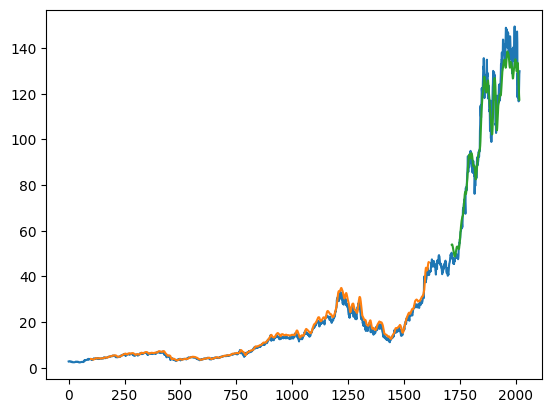

In [41]:
### Plotting 
# shift train predictions for plotting
import numpy
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(df1)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [42]:
len(test_data)

404

In [43]:
test_data=scaler.transform(test_data)

In [44]:
test_data

array([[0.96295669],
       [0.9656869 ],
       [0.9633258 ],
       [0.95806195],
       [0.96790071],
       [0.95995584],
       [0.96549023],
       [1.0023121 ],
       [1.05335134],
       [1.04085588],
       [1.06525625],
       [1.0906651 ],
       [1.08040804],
       [1.04211021],
       [1.01232321],
       [1.01977608],
       [1.04602134],
       [1.04043777],
       [1.05145726],
       [1.07236489],
       [1.07184812],
       [1.06638761],
       [1.01133923],
       [1.0173902 ],
       [1.02144881],
       [1.03957695],
       [1.02105529],
       [0.96915523],
       [0.96507212],
       [0.92736475],
       [0.99864719],
       [1.00324689],
       [0.99207973],
       [0.98858689],
       [0.98748004],
       [1.07770243],
       [1.04575061],
       [1.08136743],
       [1.08252338],
       [1.05435973],
       [1.07445554],
       [1.12239537],
       [1.1342019 ],
       [1.1364404 ],
       [1.11563115],
       [1.11659035],
       [1.0801099 ],
       [1.059

In [45]:
x_input=test_data[304:].reshape(1,-1)
x_input.shape

(1, 100)

In [46]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [47]:
temp_input

[2.7960079147325163,
 2.766726042258483,
 2.712099527763743,
 2.8228291824513496,
 2.7768147845998072,
 2.783212619808333,
 2.8966490148252326,
 2.961610594981824,
 2.974652025480101,
 2.909690633069943,
 2.9106747998734495,
 2.801421395391102,
 2.846943709840891,
 2.945370153006068,
 2.996305760368009,
 3.065204383231493,
 3.192420427722516,
 3.186514675915744,
 3.239664940205225,
 3.239418992377565,
 3.3198829832804995,
 3.160678138239717,
 3.262057081815413,
 3.2918310376911992,
 3.3181602220082795,
 3.4586640203181065,
 3.4557111444147206,
 3.3565464822736972,
 3.3774621859321923,
 3.405267432708099,
 3.3801687385150516,
 3.3981315662701608,
 3.351133001615112,
 3.18922160399147,
 3.254182996401628,
 3.2701774905497243,
 3.365158786663329,
 3.5054162616526288,
 3.585880252555563,
 3.5551217543834035,
 3.4968039572629976,
 3.571361820866293,
 3.521656703628385,
 3.533713779576722,
 3.41609439402527,
 3.371064162977234,
 3.539865479211154,
 3.512306180262907,
 3.531499498142049,
 3.4

In [48]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[2.841389]
101
1 day input [2.76672604 2.71209953 2.82282918 2.77681478 2.78321262 2.89664901
 2.96161059 2.97465203 2.90969063 2.9106748  2.8014214  2.84694371
 2.94537015 2.99630576 3.06520438 3.19242043 3.18651468 3.23966494
 3.23941899 3.31988298 3.16067814 3.26205708 3.29183104 3.31816022
 3.45866402 3.45571114 3.35654648 3.37746219 3.40526743 3.38016874
 3.39813157 3.351133   3.1892216  3.254183   3.27017749 3.36515879
 3.50541626 3.58588025 3.55512175 3.49680396 3.57136182 3.5216567
 3.53371378 3.41609439 3.37106416 3.53986548 3.51230618 3.5314995
 3.41535618 3.26943927 3.29158509 3.25270656 3.32431192 3.33366245
 3.37377109 3.49385146 3.4921287  3.42765507 3.33832682 3.24629201
 3.35063097 3.30215259 3.22611303 3.17074435 3.13112497 3.09470479
 3.13826121 3.23718669 3.35948997 3.37302461 3.36588799 3.2940318
 3.30584406 3.22709719 3.32602267 3.47760989 3.59966685 3.3710559
 3.37031768 3.2669629  3.20101246 3.16483822 3.27508368 3.20937956
 3.31125791 3.38803569 3.54159162 3.545

In [49]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [50]:
len(df1)

2017

In [51]:
lst_output

[[2.8413889408111572],
 [2.8542327880859375],
 [2.8607261180877686],
 [2.8611724376678467],
 [2.8570497035980225],
 [2.849998950958252],
 [2.8413658142089844],
 [2.8320930004119873],
 [2.8227694034576416],
 [2.813725233078003],
 [2.8051178455352783],
 [2.797006368637085],
 [2.789398670196533],
 [2.782276153564453],
 [2.7756145000457764],
 [2.769390344619751],
 [2.7635791301727295],
 [2.758160352706909],
 [2.7531166076660156],
 [2.7484283447265625],
 [2.744079351425171],
 [2.740051746368408],
 [2.736328125],
 [2.732893228530884],
 [2.7297277450561523],
 [2.7268171310424805],
 [2.7241437435150146],
 [2.721691846847534],
 [2.7194466590881348],
 [2.7173919677734375]]

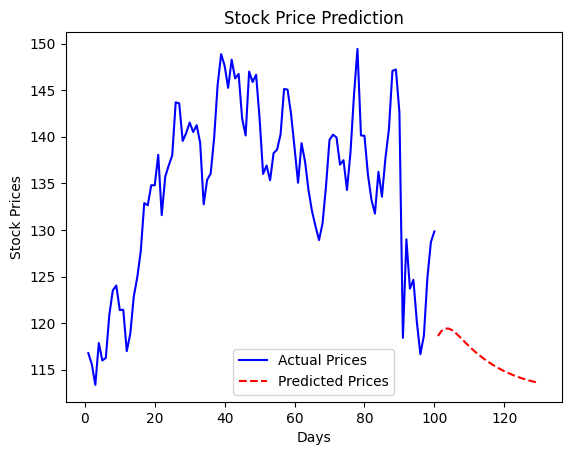

In [53]:
plt.plot(day_new,df1[1917:],label='Actual Prices', color='blue', linestyle='-')
plt.plot(day_pred,scaler.inverse_transform(lst_output), label='Predicted Prices', color='red', linestyle='--')
plt.xlabel("Days")
plt.ylabel("Stock Prices")
plt.title("Stock Price Prediction")
plt.legend()

In [54]:
lst_output

[[2.8413889408111572],
 [2.8542327880859375],
 [2.8607261180877686],
 [2.8611724376678467],
 [2.8570497035980225],
 [2.849998950958252],
 [2.8413658142089844],
 [2.8320930004119873],
 [2.8227694034576416],
 [2.813725233078003],
 [2.8051178455352783],
 [2.797006368637085],
 [2.789398670196533],
 [2.782276153564453],
 [2.7756145000457764],
 [2.769390344619751],
 [2.7635791301727295],
 [2.758160352706909],
 [2.7531166076660156],
 [2.7484283447265625],
 [2.744079351425171],
 [2.740051746368408],
 [2.736328125],
 [2.732893228530884],
 [2.7297277450561523],
 [2.7268171310424805],
 [2.7241437435150146],
 [2.721691846847534],
 [2.7194466590881348],
 [2.7173919677734375]]

In [55]:
scaled_output= scaler.inverse_transform(lst_output)
print(scaled_output)

[[118.61608468]
 [119.13801618]
 [119.40188365]
 [119.42002061]
 [119.25248632]
 [118.96596703]
 [118.61514489]
 [118.23832839]
 [117.85944822]
 [117.49192303]
 [117.14214725]
 [116.81252363]
 [116.50337191]
 [116.21393638]
 [115.9432288 ]
 [115.69029969]
 [115.45415114]
 [115.23394994]
 [115.02898881]
 [114.8384733 ]
 [114.66174458]
 [114.49807603]
 [114.34676036]
 [114.20717752]
 [114.07854273]
 [113.960265  ]
 [113.85162737]
 [113.75199039]
 [113.66075338]
 [113.57725752]]


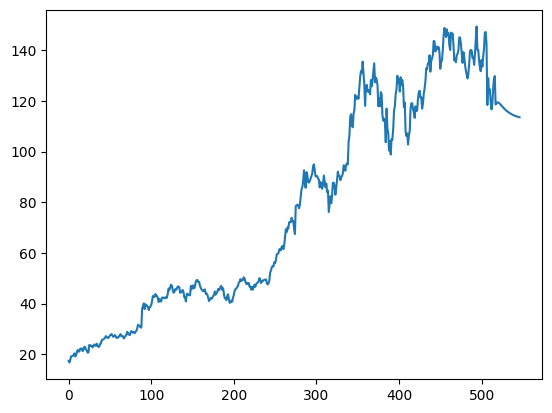

In [56]:
df3=df1.tolist()
df3.extend(scaled_output)
plt.plot(df3[1500:])